In [1]:
!pip install split_folders
import splitfolders
splitfolders.ratio("../input/multidiseasedataset/Augumented Data", output="MultiDisease", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 45759 files [06:11, 123.21 files/s]


In [2]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications.resnet import ResNet50 #For Transfer Learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical
import albumentations as A
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import clone_model
from sklearn.metrics import classification_report, accuracy_score



In [3]:
channels=3
batch_size=25
test_batch_size=32
test_steps=1
train_path = './MultiDisease/train'
test_path = './MultiDisease/test'
val_path = './MultiDisease/val'
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

def ultimate_preprocessing(img):
    img = (img * 255).astype(np.uint8) if img.dtype == np.float32 else img
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  

    transform = A.Compose([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),  
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),  
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5), 
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  
        A.Cutout(num_holes=1, max_h_size=16, max_w_size=16, fill_value=0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),  
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  
    ])

    augmented = transform(image=img)
    return augmented['image']
    
def scalar(img):
    return img  
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_generator=trgen.flow_from_directory( directory=train_path , target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_generator=tvgen.flow_from_directory( directory=test_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_generator=tvgen.flow_from_directory( directory=val_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_generator.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_generator.labels)/batch_size))

test batch size:  32   test steps:  1
Found 36598 images belonging to 28 classes.
Found 4598 images belonging to 28 classes.
Found 4563 images belonging to 28 classes.


In [4]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

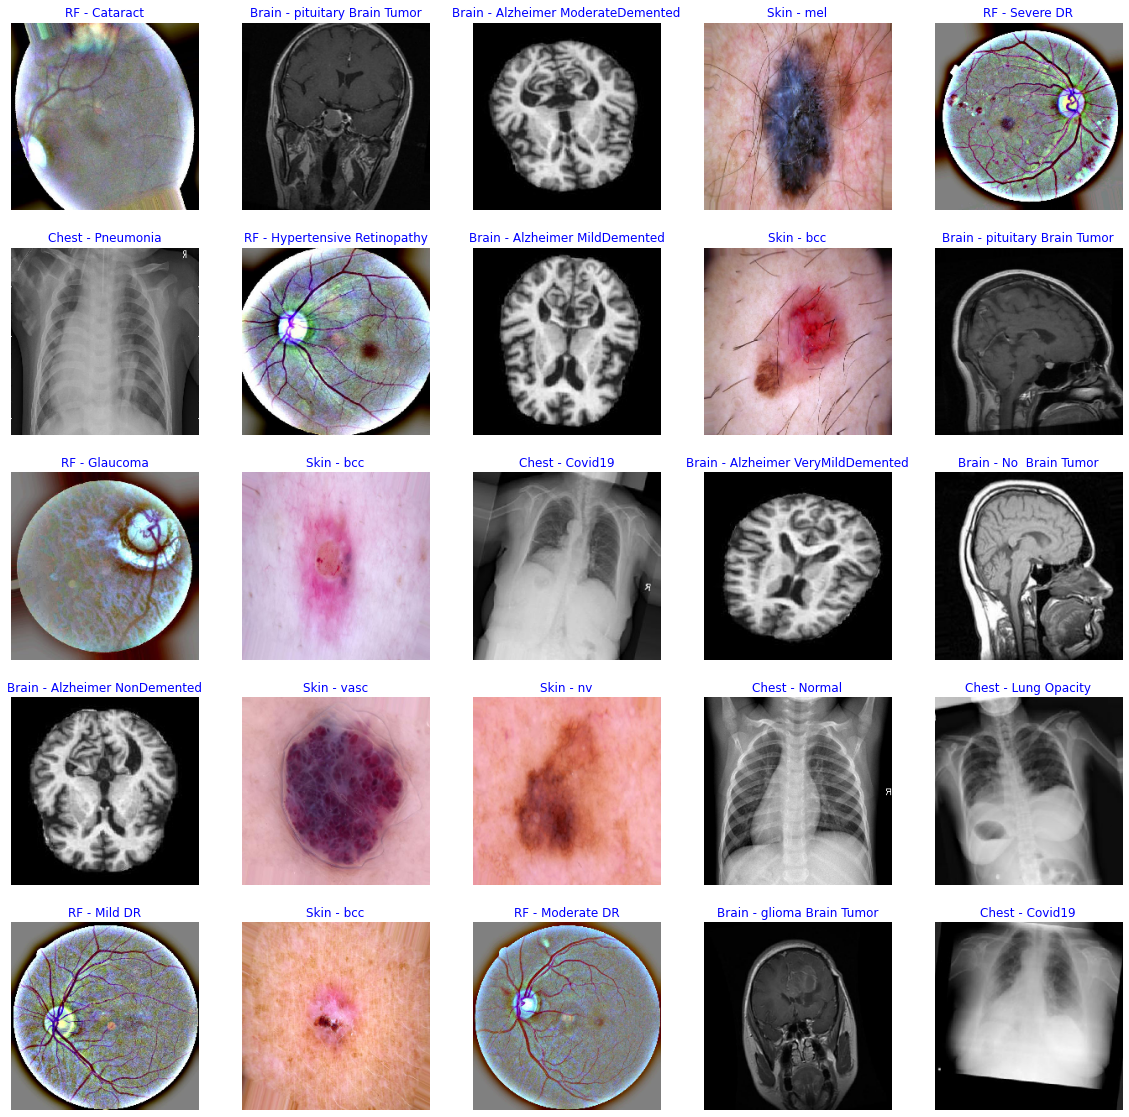

In [5]:
show_image_samples(train_generator)

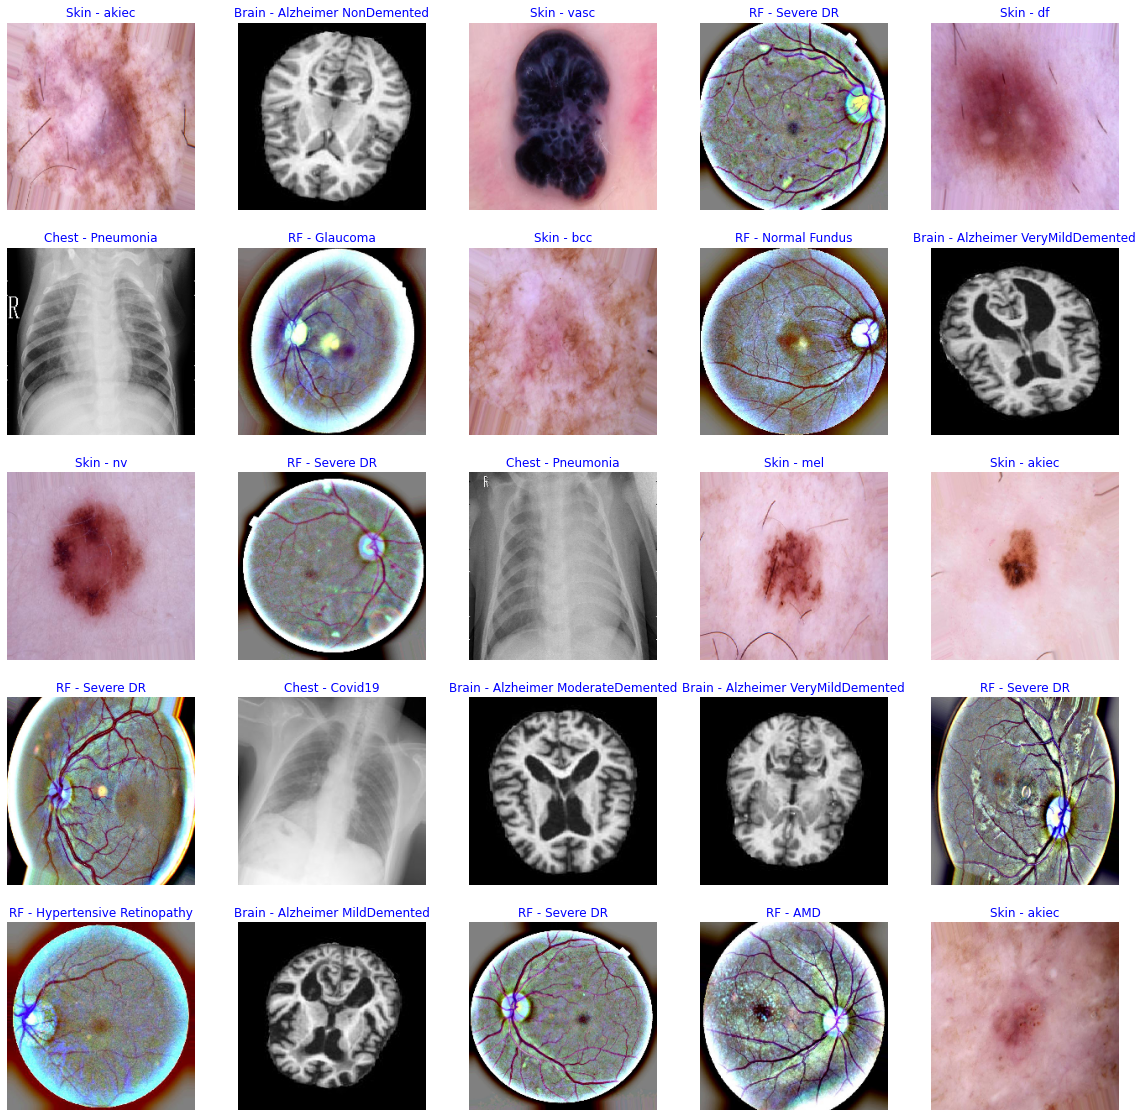

In [6]:
show_image_samples(valid_generator)

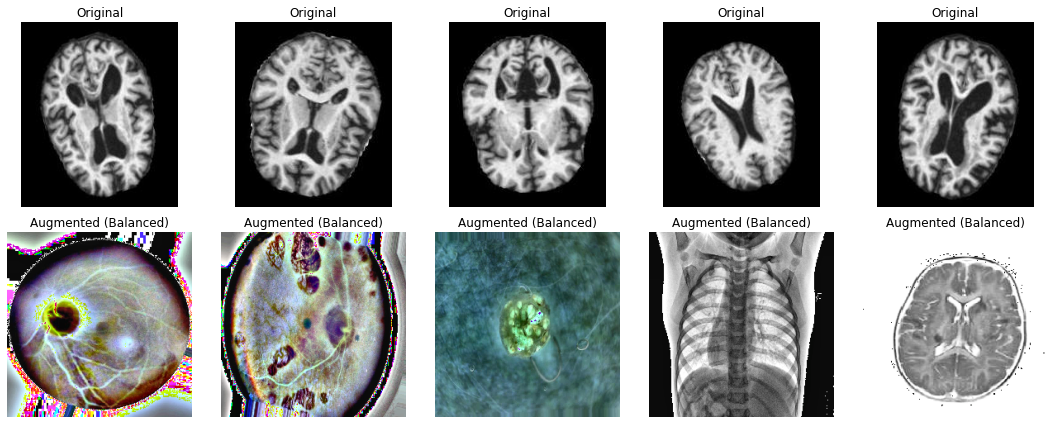

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

batch_images, batch_labels = next(train_generator)

num_images = 5  
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

def preprocess_augmented_image(img):
    if img.dtype == np.float32 or np.max(img) <= 1:  
        img = (img * 255).astype(np.uint8)  
    
    img = np.clip(img, 0, 255) 
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  
    
    img = cv2.convertScaleAbs(img, alpha=1.1, beta=8) 
    
    img = cv2.GaussianBlur(img, (1, 1), 0) 
    
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))  
    l = clahe.apply(l)
    
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    return img

for i in range(num_images):
    orig_img = cv2.imread(train_generator.filepaths[i])
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    aug_img = preprocess_augmented_image(batch_images[i])

    axes[0, i].imshow(orig_img)
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(aug_img)
    axes[1, i].set_title("Augmented (Balanced)")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [8]:
print("Class Names:")
for class_name in classes:
    print(class_name)

Class Names:
Brain - Alzheimer MildDemented
Brain - Alzheimer ModerateDemented
Brain - Alzheimer NonDemented
Brain - Alzheimer VeryMildDemented
Brain - No  Brain Tumor
Brain - glioma Brain Tumor
Brain - meningioma Brain Tumor
Brain - pituitary Brain Tumor
Chest - Covid19
Chest - Lung Opacity
Chest - Normal
Chest - Pneumonia
RF - AMD
RF - Cataract
RF - Glaucoma
RF - Hypertensive Retinopathy
RF - Mild DR
RF - Moderate DR
RF - Normal Fundus
RF - Proliferate DR
RF - Severe DR
Skin - akiec
Skin - bcc
Skin - bkl
Skin - df
Skin - mel
Skin - nv
Skin - vasc


In [9]:

train_count = len(train_generator.labels)
test_count = len(test_generator.labels)
val_count = len(valid_generator.labels)


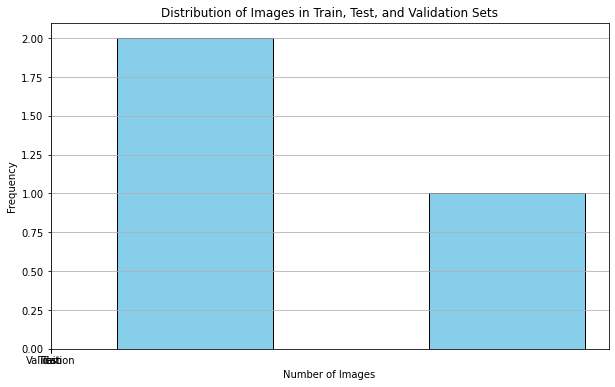

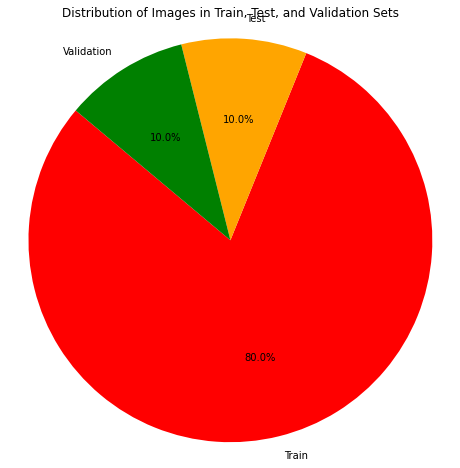

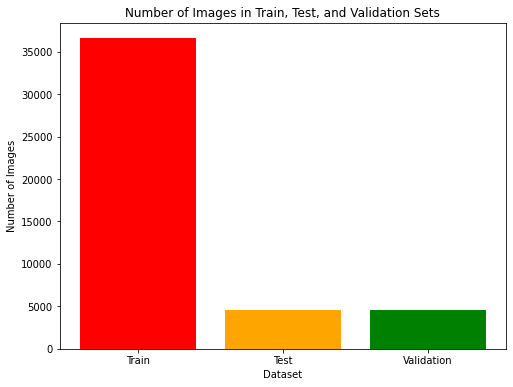

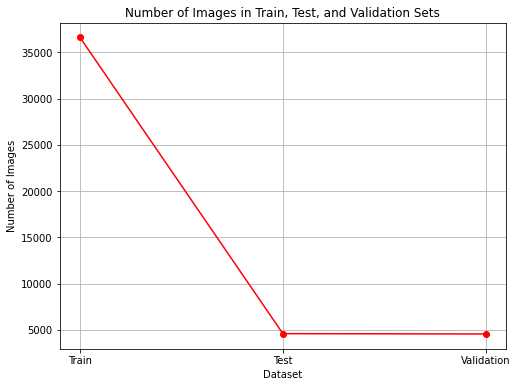

In [10]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist([train_count, test_count, val_count], bins=3, color='skyblue', edgecolor='black')
plt.title('Distribution of Images in Train, Test, and Validation Sets')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.xticks(np.arange(3), ['Train', 'Test', 'Validation'])
plt.grid(True)
plt.show()


# Plot pie chart
plt.figure(figsize=(8, 8))
labels = ['Train', 'Test', 'Validation']
sizes = [train_count, test_count, val_count]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['red', 'orange', 'green'])
plt.axis('equal')
plt.title('Distribution of Images in Train, Test, and Validation Sets')
plt.show()

# Plot bar graph
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Test', 'Validation'], [train_count, test_count, val_count], color=['red', 'orange', 'green'])
plt.title('Number of Images in Train, Test, and Validation Sets')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.show()

# Plot line graph
plt.figure(figsize=(8, 6))
datasets = ['Train', 'Test', 'Validation']
counts = [train_count, test_count, val_count]
plt.plot(datasets, counts, marker='o', linestyle='-', color='r')
plt.title('Number of Images in Train, Test, and Validation Sets')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()

In [11]:
def count_images_in_directory(directory):
    count = 0
    # Iterate through all files and subdirectories in the given directory
    for root, dirs, files in os.walk(directory):
        # Count the number of files with image extensions (adjust this if needed)
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                count += 1
    return count

# Example usage:
dataset_directory = '/kaggle/input/multidiseasedataset/Augumented Data'
total_images = count_images_in_directory(dataset_directory)
print("Total number of images in the dataset:", total_images)


Total number of images in the dataset: 45759


In [12]:
import os

def count_images_in_datasets(parent_directory):
    dataset_counts = {}
    # Iterate through all directories in the parent directory
    for dataset_dir in os.listdir(parent_directory):
        dataset_path = os.path.join(parent_directory, dataset_dir)
        # Skip if it's not a directory
        if not os.path.isdir(dataset_path):
            continue
        # Count images in the dataset directory
        image_count = count_images_in_directory(dataset_path)
        dataset_counts[dataset_dir] = image_count
    return dataset_counts

def count_images_in_directory(directory):
    count = 0
    # Iterate through all files and subdirectories in the given directory
    for root, dirs, files in os.walk(directory):
        # Count the number of files with image extensions (adjust this if needed)
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                count += 1
    return count

# Example usage:
parent_directory = '/kaggle/input/multidiseasedataset/Augumented Data'
dataset_counts = count_images_in_datasets(parent_directory)
for dataset, count in dataset_counts.items():
    print(f"Dataset '{dataset}' contains {count} images.")


Dataset 'Brain - glioma Brain Tumor' contains 1382 images.
Dataset 'Chest - Normal' contains 1341 images.
Dataset 'RF - Mild DR' contains 1974 images.
Dataset 'Skin - df' contains 1581 images.
Dataset 'Brain - Alzheimer MildDemented' contains 1749 images.
Dataset 'RF - Hypertensive Retinopathy' contains 1220 images.
Dataset 'RF - Proliferate DR' contains 1295 images.
Dataset 'Skin - vasc' contains 1791 images.
Dataset 'Skin - akiec' contains 1506 images.
Dataset 'Chest - Covid19' contains 1931 images.
Dataset 'Skin - nv' contains 1905 images.
Dataset 'Chest - Lung Opacity' contains 1600 images.
Dataset 'RF - Severe DR' contains 1586 images.
Dataset 'Brain - Alzheimer NonDemented' contains 2067 images.
Dataset 'Skin - bkl' contains 1958 images.
Dataset 'Brain - pituitary Brain Tumor' contains 1365 images.
Dataset 'Brain - Alzheimer ModerateDemented' contains 1424 images.
Dataset 'RF - Glaucoma' contains 1678 images.
Dataset 'Chest - Pneumonia' contains 1968 images.
Dataset 'Brain - Alzh

In [13]:
import torch
import torch.nn as nn

# Self Attention Model
class SelfAttentionModel(nn.Module):
    def __init__(self):
        super(SelfAttentionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, class_name)
        self.pool = nn.MaxPool2d(2, 2)
        self.channel_att = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        channel_att = self.channel_att(x.mean(dim=(2, 3)))
        x = x * channel_att.unsqueeze(2).unsqueeze(3)
        x = x.view(-1, 128 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def EfficientNetB4(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNetB4(
        1.4,
        1.8,
        380,
        0.4,
        model_name="efficientnetb4",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


In [14]:
from keras.applications.efficientnet import EfficientNetB4

Self_Attention_model = EfficientNetB4(include_top = False, weights = 'imagenet', input_shape = (224,224,3), classes = 28)

71696384/71686520 [==============================] - 0s 0us/step


In [15]:
model= Sequential()
model.add(Self_Attention_model)
model.add(Flatten())

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
flatten (Flatten)            (None, 87808)             0         
Total params: 17,673,823
Trainable params: 17,548,616
Non-trainable params: 125,207
_________________________________________________________________


In [17]:
# Get all image file paths and corresponding labels
image_paths = []
labels = []
label_map = {}

base_path = './MultiDisease/train'

for i, class_name in enumerate(sorted(os.listdir(base_path))):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        label_map[i] = class_name
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            labels.append(i)

image_paths = np.array(image_paths)
labels = np.array(labels)

In [18]:
from sklearn.model_selection import StratifiedKFold

k = 5  # Use 3-fold to save time, can increase to 5 if desired
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


In [19]:
def get_generators(train_idx, val_idx):
    train_files = image_paths[train_idx]
    train_labels = labels[train_idx]
    val_files = image_paths[val_idx]
    val_labels = labels[val_idx]

    # Create directories or use custom generator if needed
    # Here we use a workaround via a dataframe + flow_from_dataframe
    import pandas as pd

    train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})

    train_df['class'] = train_df['class'].astype(str)
    val_df['class'] = val_df['class'].astype(str)

    datagen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)

    train_gen = datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                            target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=batch_size)

    val_gen = datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                          target_size=(224,224), class_mode='categorical', shuffle=False, batch_size=batch_size)

    return train_gen, val_gen


In [20]:
history_all_folds = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}



--- Fold 1/5 ---
Found 29278 validated image filenames belonging to 28 classes.
Found 7320 validated image filenames belonging to 28 classes.
Epoch 1/15
1172/1172 [==============================] - 813s 673ms/step - loss: 1.2949 - accuracy: 0.5180 - val_loss: 0.8811 - val_accuracy: 0.6602
Epoch 2/15
1172/1172 [==============================] - 786s 671ms/step - loss: 0.8307 - accuracy: 0.6708 - val_loss: 0.7684 - val_accuracy: 0.7113
Epoch 3/15
1172/1172 [==============================] - 786s 671ms/step - loss: 0.6823 - accuracy: 0.7287 - val_loss: 0.6201 - val_accuracy: 0.7440
Epoch 4/15
1172/1172 [==============================] - 785s 670ms/step - loss: 0.6591 - accuracy: 0.7394 - val_loss: 0.5775 - val_accuracy: 0.7661
Epoch 5/15
1172/1172 [==============================] - 785s 670ms/step - loss: 0.5935 - accuracy: 0.7674 - val_loss: 0.6767 - val_accuracy: 0.7552
Epoch 6/15
1172/1172 [==============================] - 780s 666ms/step - loss: 0.5444 - accuracy: 0.7807 - val_loss:

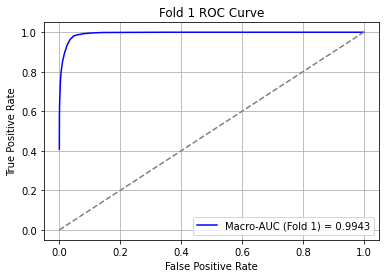


--- Fold 2/5 ---
Found 29278 validated image filenames belonging to 28 classes.
Found 7320 validated image filenames belonging to 28 classes.
Epoch 1/15
1172/1172 [==============================] - 796s 667ms/step - loss: 0.6696 - accuracy: 0.7844 - val_loss: 0.4148 - val_accuracy: 0.8306
Epoch 2/15
1172/1172 [==============================] - 780s 665ms/step - loss: 0.4702 - accuracy: 0.8251 - val_loss: 0.4319 - val_accuracy: 0.8445
Epoch 3/15
1172/1172 [==============================] - 779s 665ms/step - loss: 0.4381 - accuracy: 0.8337 - val_loss: 0.3782 - val_accuracy: 0.8486
Epoch 4/15
1172/1172 [==============================] - 780s 665ms/step - loss: 0.4171 - accuracy: 0.8417 - val_loss: 0.4693 - val_accuracy: 0.8388
Epoch 5/15
1172/1172 [==============================] - 780s 666ms/step - loss: 0.3865 - accuracy: 0.8478 - val_loss: 0.4620 - val_accuracy: 0.8389
Epoch 6/15
1172/1172 [==============================] - 780s 665ms/step - loss: 0.4590 - accuracy: 0.8353 - val_loss:

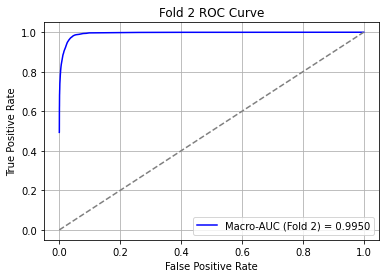


--- Fold 3/5 ---
Found 29278 validated image filenames belonging to 28 classes.
Found 7320 validated image filenames belonging to 28 classes.
Epoch 1/15
1172/1172 [==============================] - 798s 669ms/step - loss: 0.5589 - accuracy: 0.8229 - val_loss: 0.3034 - val_accuracy: 0.8814
Epoch 2/15
1172/1172 [==============================] - 782s 667ms/step - loss: 0.3670 - accuracy: 0.8653 - val_loss: 0.3226 - val_accuracy: 0.8811
Epoch 3/15
1172/1172 [==============================] - 787s 672ms/step - loss: 0.3437 - accuracy: 0.8735 - val_loss: 0.3562 - val_accuracy: 0.8698
Epoch 4/15
1172/1172 [==============================] - 781s 666ms/step - loss: 0.3568 - accuracy: 0.8709 - val_loss: 0.3009 - val_accuracy: 0.8858
Epoch 5/15
1172/1172 [==============================] - 780s 666ms/step - loss: 0.3046 - accuracy: 0.8862 - val_loss: 0.3180 - val_accuracy: 0.8936
Epoch 6/15
1172/1172 [==============================] - 783s 668ms/step - loss: 0.3057 - accuracy: 0.8871 - val_loss:

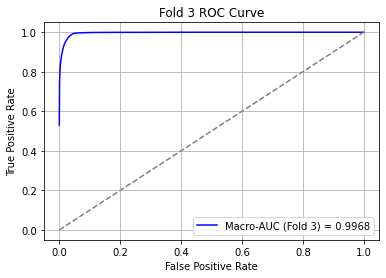


--- Fold 4/5 ---
Found 29279 validated image filenames belonging to 28 classes.
Found 7319 validated image filenames belonging to 28 classes.
Epoch 1/15
1172/1172 [==============================] - 813s 681ms/step - loss: 0.4557 - accuracy: 0.8573 - val_loss: 0.3579 - val_accuracy: 0.8859
Epoch 2/15
1172/1172 [==============================] - 793s 677ms/step - loss: 0.3461 - accuracy: 0.8820 - val_loss: 0.2269 - val_accuracy: 0.9130
Epoch 3/15
1172/1172 [==============================] - 794s 677ms/step - loss: 0.2817 - accuracy: 0.9015 - val_loss: 0.2908 - val_accuracy: 0.9027
Epoch 4/15
1172/1172 [==============================] - 787s 671ms/step - loss: 0.2990 - accuracy: 0.8965 - val_loss: 0.2433 - val_accuracy: 0.9044
Epoch 5/15
1172/1172 [==============================] - 793s 677ms/step - loss: 0.2407 - accuracy: 0.9117 - val_loss: 0.2108 - val_accuracy: 0.9229
Epoch 6/15
1172/1172 [==============================] - 793s 677ms/step - loss: 0.2892 - accuracy: 0.9023 - val_loss:

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

acc_scores = []
auc_scores = []
num_classes = 28

# Store all folds' ROC data
fold_fprs = []
fold_tprs = []
fold_labels = []

for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"\n--- Fold {fold+1}/{k} ---")

    train_gen, val_gen = get_generators(train_idx, val_idx)

    model = Sequential()
    model.add(Self_Attention_model)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_gen, epochs=10, validation_data=val_gen, verbose=1)

    val_acc = history.history['val_accuracy'][-1]
    acc_scores.append(val_acc)

    history_all_folds['loss'].extend(history.history['loss'])
    history_all_folds['accuracy'].extend(history.history['accuracy'])
    history_all_folds['val_loss'].extend(history.history['val_loss'])
    history_all_folds['val_accuracy'].extend(history.history['val_accuracy'])

    # ---------- ROC AUC Part ----------
    y_true = val_gen.classes
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_prob = model.predict(val_gen, verbose=0)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    roc_auc["macro"] = auc(all_fpr, mean_tpr)
    auc_scores.append(roc_auc["macro"])

    # Store for combined plot later
    fold_fprs.append(all_fpr)
    fold_tprs.append(mean_tpr)
    fold_labels.append(f'Fold {fold+1} (AUC = {roc_auc["macro"]:.4f})')

    # Plot per-fold ROC
    plt.figure()
    plt.plot(all_fpr, mean_tpr, color='blue', label=f'Macro-AUC (Fold {fold+1}) = {roc_auc["macro"]:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Fold {fold+1} ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# 📊 Plot all folds' macro-averaged ROC curves in one combined plot
plt.figure(figsize=(10, 7))

for i in range(len(fold_fprs)):
    plt.plot(fold_fprs[i], fold_tprs[i], label=fold_labels[i])

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve - All Folds (Macro-Averaged)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
print("\nK-Fold Validation Accuracy Results:")
for i, acc in enumerate(acc_scores):
    print(f"Fold {i+1}: {acc:.4f}")

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

print(f"\nMean Accuracy: {mean_acc:.4f}")
print(f"Standard Deviation: {std_acc:.4f}")

In [ ]:
for i, acc in enumerate(acc_scores):
    print(f"Fold {i+1}: {acc:.4f}")

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

print(f"\nMean Accuracy: {mean_acc:.4f}")
print(f"Standard Deviation: {std_acc:.4f}")

In [ ]:
'''learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])'''

In [ ]:
#model.fit(train_generator,epochs = 10, validation_data = valid_generator, verbose = 1)

In [ ]:
#model.fit(train_generator,initial_epoch=10, epochs = 15, validation_data = valid_generator, verbose = 1)

In [ ]:
model.summary()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Loads and preprocesses an image for model input."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 
    return img_array

def get_intermediate_layer_outputs(model, layer_names, input_data):
    """Extracts activations from intermediate layers."""
    intermediate_layer_model = Model(
        inputs=model.input, 
        outputs=[model.get_layer(name).output for name in layer_names]
    )
    activations = intermediate_layer_model.predict(input_data)
    return activations


efficientnet_model = model  

efficientnet_base = efficientnet_model.get_layer("efficientnetb4")


layer_names = [
    'block2a_expand_activation', 
    'block4a_expand_activation',
    'block6a_expand_activation'   
]

img_path = '/kaggle/input/multidiseasedataset/Augumented Data/Brain - meningioma Brain Tumor/meningioma Brain Tumor_0_115.jpeg'  
sample_input = load_and_preprocess_image(img_path)

activations = get_intermediate_layer_outputs(efficientnet_base, layer_names, sample_input)

def plot_selected_heatmaps(activations, layer_names, num_filters=3):
    """Visualizes feature maps from selected layers."""
    for activation, layer_name in zip(activations, layer_names):
        num_filters_available = activation.shape[-1]  
        num_filters_to_show = min(num_filters, num_filters_available)  
        
        fig, axes = plt.subplots(1, num_filters_to_show, figsize=(15, 5))
        fig.suptitle(f"Feature Maps - {layer_name}", fontsize=16, fontweight='bold')

        if num_filters_to_show == 1:
            axes = [axes]

        for j in range(num_filters_to_show):
            ax = axes[j]
            ax.imshow(activation[0, :, :, j], cmap='inferno')
            ax.axis('off')
            ax.set_title(f'Filter {j}', fontsize=12)

        plt.tight_layout()
        plt.show()

# Plot feature maps
plot_selected_heatmaps(activations, layer_names, num_filters=3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Load and preprocess an image."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0  
    return img_array

img_path = '/kaggle/input/multidiseasedataset/Augumented Data/Brain - meningioma Brain Tumor/meningioma Brain Tumor_0_115.jpeg'  
sample_input = load_and_preprocess_image(img_path)

efficientnet_base = model.get_layer("efficientnetb4")  

layer_names = [
    'block2a_expand_activation',  
    'block4a_expand_activation',  
    'block6a_expand_activation'  
]

intermediate_model = Model(
    inputs=efficientnet_base.input,  
    outputs=[efficientnet_base.get_layer(layer).output for layer in layer_names]
)

feature_maps = intermediate_model.predict(sample_input)

def plot_feature_maps(feature_maps, layer_names, num_filters=6):
    """Plot feature maps from selected layers."""
    for fmap, layer_name in zip(feature_maps, layer_names):
        num_filters_available = fmap.shape[-1]  
        filters_to_show = min(num_filters, num_filters_available) 
        
        fig, axes = plt.subplots(1, filters_to_show, figsize=(15, 5))
        fig.suptitle(f"Feature Maps - {layer_name}", fontsize=16, fontweight='bold')

        if filters_to_show == 1:
            axes = [axes]  

        for i in range(filters_to_show):
            ax = axes[i]
            ax.imshow(fmap[0, :, :, i], cmap='inferno')
            ax.axis('off')
            ax.set_title(f'Filter {i}', fontsize=12)

        plt.show()

plot_feature_maps(feature_maps, layer_names, num_filters=6)


In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             
    classes=list(new_dict.values())     
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value) 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
 
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) 
    return

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
p = model.predict(test_generator)
print_info( test_generator, p, 10, r'./', 'MultiDisease' )

In [ ]:
model.evaluate(test_generator)

In [ ]:
show_image_samples(test_generator)

In [ ]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80))
    # now create the class_df and convert to csv file
    class_dict=generator.class_indices
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class')
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80))
    return model_save_loc, csv_save_loc


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def tr_plot(tr_data, start_epoch=0):
    """Plot training history."""
    tacc = tr_data['accuracy']
    tloss = tr_data['loss']
    vacc = tr_data['val_accuracy']
    vloss = tr_data['val_loss']

    epochs = range(start_epoch, len(tacc))

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tacc, 'b', label='Training Accuracy')
    plt.plot(epochs, vacc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tloss, 'b', label='Training Loss')
    plt.plot(epochs, vloss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the MobileNetV2 model without URL
mobile_net_v2 = tf.keras.applications.MobileNetV2(weights='imagenet')
# Create a sequential model and add MobileNetV2 as a layer
gender_model = tf.keras.Sequential([mobile_net_v2])


In [ ]:
# Use the pre-trained model to predict genders for your entire dataset
# Run inference on each image in your dataset and obtain predicted gender labels
import os
import cv2
import numpy as np

# Path to your dataset folder
dataset_folder = "/kaggle/input/multidiseasedataset/Augumented Data"

# List all image files in the dataset folder
image_files = [os.path.join(dataset_folder, file) for file in os.listdir(dataset_folder) if file.endswith('.jpg')]

# Function to preprocess images for the pre-trained model
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize image to match model input shape
    image = image / 255.0  # Normalize pixel values
    return image

# Make predictions for each image in the dataset
predicted_genders = []
for image_path in image_files:
    preprocessed_image = preprocess_image(image_path)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
    prediction = gender_model.predict(preprocessed_image)
    predicted_gender = "male" if prediction >= 0.5 else "female"  # Threshold for binary classification
    predicted_genders.append(predicted_gender)


In [ ]:
import imgaug.augmenters as iaa

# Define augmentation pipeline
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flips
    iaa.Rotate((-10, 10)),  # Rotate images
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Add Gaussian blur
    iaa.Affine(scale=(0.8, 1.2)),  # Scale images
])

# Apply augmentation to each image in the dataset
augmented_data = []
for image_path, predicted_gender in zip(image_files, predicted_genders):
    image = cv2.imread(image_path)
    augmented_images = augmenter(images=[image])
    for augmented_image in augmented_images:
        augmented_data.append((augmented_image, predicted_gender))


In [ ]:
# Function to predict gender from an image
def predict_gender(image):
    preprocessed_image = preprocess_image(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
    prediction = gender_model.predict(preprocessed_image)
    predicted_gender = "male" if prediction >= 0.5 else "female"  # Threshold for binary classification
    return predicted_gender

# Function to predict gender from an image
def predict_gender(image_path):
    # Read the image from file
    image = cv2.imread(image_path)
    # Preprocess the image
    preprocessed_image = preprocess_image(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
    # Predict gender
    prediction = gender_model.predict(preprocessed_image)
    # Check if prediction is greater than or equal to 0.5 for each element in the array
    if prediction[0][0] >= 0.5:
        predicted_gender = "male"
    else:
        predicted_gender = "female"
    return predicted_gender


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt 

# Load a pre-trained gender classification model from TensorFlow Hub

# Load the MobileNetV2 model without URL
mobile_net_v2 = tf.keras.applications.MobileNetV2(weights='imagenet')
# Create a sequential model and add MobileNetV2 as a layer
gender_model = tf.keras.Sequential([mobile_net_v2])


# Function to preprocess images for the pre-trained model
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))  # Resize image to match model input shape
    image = image / 255.0  # Normalize pixel values
    return image

# Function to predict gender and class from an image
def predict_gender(image_path):
    # Read the image from file
    image = cv2.imread(image_path)
    # Preprocess the image
    preprocessed_image = preprocess_image(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
    # Predict gender
    prediction = gender_model.predict(preprocessed_image)
    # Check each element of the prediction array individually
    predicted_gender = "male" if prediction[0][0] >= 0.5 else "female"  # Assuming male is at index 0
    # Get the predicted class name
    class_name = "Brain - No Brain Tumor" if predicted_gender == "female" else "Brain - Tumor"
    return predicted_gender, class_name, image

# Example usage:
image_path = "/kaggle/input/multidiseasedataset/Augumented Data/Brain - No  Brain Tumor/No  Brain Tumor_0_1034.jpeg"
# Predict gender, class, and get the image
gender, class_name, image = predict_gender(image_path)
print("Predicted gender:", gender)
print("Predicted class:", class_name)

# Show the image along with predicted gender and class name
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Gender: {gender}, Predicted Class: {class_name}")
plt.axis('off')
plt.show()

In [ ]:
from datetime import datetime

# Load the MobileNetV2 model without URL
age_mobile_net_v2 = tf.keras.applications.MobileNetV2(weights='imagenet')
# Create a sequential model and add MobileNetV2 as a layer
age_model = tf.keras.Sequential([age_mobile_net_v2])
# Function to predict age from an image
def predict_age(image):
    preprocessed_image = preprocess_image(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
    prediction = age_model(preprocessed_image)
    predicted_age = np.argmax(prediction[0])  # Assuming the model outputs age classes
    
    # Convert predicted age to years and months
    years = predicted_age // 12
    months = predicted_age % 12
    
    return years, months

# Example usage:
image_path = "/kaggle/input/multidiseasedataset/Augumented Data/Chest - Normal/IM-0131-0001.jpeg"  # Replace with the path to your image
image = cv2.imread(image_path)
predicted_years, predicted_months = predict_age(image)
print("Predicted Age:", predicted_years, "years and", predicted_months, "months")

# Display the image along with the predicted age
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Age: {predicted_years} years and {predicted_months} months")
plt.axis('off')
plt.show()


In [ ]:
model.save('Self_attention_model')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Step 1: Predict on test set
y_score = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=1)

# Step 2: True labels
y_true = test_generator.classes
y_true = label_binarize(y_true, classes=range(class_count))  # One-hot encoding for ROC curve

# Step 3: ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(class_count):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(class_count):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - {layer.__class__.__name__}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
import os

# ---- Configuration ----
IMG_SIZE = (224, 224)
CLASS_NAMES = list(train_generator.class_indices.keys())
LAST_CONV_LAYER = 'top_activation'  # Adjust if your model ends differently

# ---- Function: Generate Grad-CAM Heatmap ----
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(inputs=[model.inputs], outputs=[
        model.get_layer(last_conv_layer_name).output,
        model.output
    ])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ---- Function: Overlay Heatmap on Image ----
def overlay_heatmap(original_img_path, heatmap, output_path="cam_result.jpg", alpha=0.4):
    original_img = cv2.imread(original_img_path)
    original_img = cv2.resize(original_img, IMG_SIZE)

    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = heatmap_color * alpha + original_img

    cv2.imwrite(output_path, superimposed)
    plt.imshow(cv2.cvtColor(superimposed.astype("uint8"), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()

# ---- Load Sample Image and Run Grad-CAM ----
# Pick a sample image from test set
sample_class = os.listdir(test_path)[0]
sample_img = os.listdir(os.path.join(test_path, sample_class))[0]
sample_path = os.path.join(test_path, sample_class, sample_img)

# Preprocess image
img = load_img(sample_path, target_size=IMG_SIZE)
img_array = img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER)

# Overlay and display
overlay_heatmap(sample_path, heatmap)
